In [5]:
# ===================================================
# 1️⃣ Imports
# ===================================================
import torch, torchvision
from torchvision import transforms
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights


In [6]:
# ===================================================
# 2️⃣ Config (minimal & generic)
# ===================================================

BATCH_SIZE = 16
ROT_DEG = 90
NOISE_STD = 0.05
NUM_WORKERS = 2
PIN_MEMORY = torch.cuda.is_available()
IMG_SIZE = 384

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ImageNet normalization (EfficientNetV2 default)
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

In [7]:

# ===================================================
# 3️⃣ Transforms
# ===================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=ROT_DEG, translate=(0.05, 0.05),
                             scale=(0.95, 1.05), fill=0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t + torch.randn_like(t) * NOISE_STD),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.Normalize(mean=MEAN, std=STD),
    #transforms.RandomErasing(p=0.25, scale=(0.02, 0.1))
])

val_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])


In [8]:

# ===================================================
# 4️⃣ Dataset & DataLoaders
# ===================================================
data_root = '/90daydata/nematode_ml/BLD/NematodeDataset'

train_dataset = torchvision.datasets.ImageFolder(
    root=f'{data_root}/train', transform=train_transform
)
val_dataset = torchvision.datasets.ImageFolder(
    root=f'{data_root}/val', transform=val_transform
)

# Safety check: class order matches
assert set(train_dataset.classes) == set(val_dataset.classes), \
    "Class names differ between train and val."

# Remap val set to train set's ordering
val_to_train = {
    val_dataset.class_to_idx[label]: train_dataset.class_to_idx[label]
    for label in train_dataset.classes
}
val_dataset.samples = [(p, val_to_train[y]) for (p, y) in val_dataset.samples]
val_dataset.targets = [y for _, y in val_dataset.samples]
val_dataset.classes = train_dataset.classes
val_dataset.class_to_idx = train_dataset.class_to_idx

CLASSES = train_dataset.classes
print(f"Classes: {CLASSES}")

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=True
)
valloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
    persistent_workers=True
)
CLASSES = train_dataset.classes
class_mapping = train_dataset.class_to_idx  # <- add this
print(f"Classes: {CLASSES}")
print(f"Mapping: {class_mapping}")

Classes: ['BLD', 'No_BLD']
Classes: ['BLD', 'No_BLD']
Mapping: {'BLD': 0, 'No_BLD': 1}


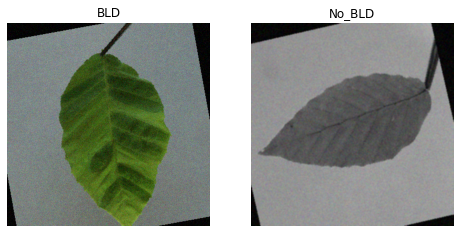

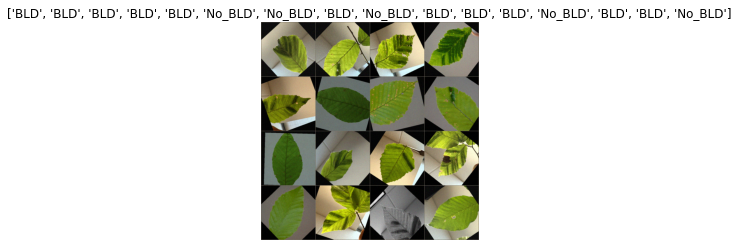

In [6]:
# ==============================
# 7️⃣ Visualization Helpers
# ==============================
def denormalize(img_tensor):
    """Undo normalization for visualization."""
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = STD * img + MEAN
    return np.clip(img, 0, 1)

def imshow(img_tensor, title=None):
    plt.imshow(denormalize(img_tensor))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# ==============================
# 8️⃣ One Example Per Class
# ==============================
class_examples = {}
for img, label in train_dataset:
    if label not in class_examples:
        class_examples[label] = img
    if len(class_examples) == len(train_dataset.classes):
        break

fig = plt.figure(figsize=(8,4))
for label, img in class_examples.items():
    ax = fig.add_subplot(1, len(CLASSES), label+1)
    ax.imshow(denormalize(img))
    ax.set_title(CLASSES[label])
    ax.axis('off')
plt.show()

# ==============================
# 9️⃣ Show a Batch of Images
# ==============================
inputs, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out, title=[CLASSES[x] for x in labels])

In [ ]:
import torch

# Clear any existing model from memory
del model  
torch.cuda.empty_cache()


In [ ]:
#EfficientNet-B0

# ===================================================
# 6️⃣ Model setup (CrossEntropyLoss / 2‑logit version)
# ===================================================


from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load EfficientNet‑B0 with pretrained weights
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)

# Freeze backbone parameters & BN stats
for p in model.features.parameters():
    p.requires_grad = False
for m in model.features.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        m.requires_grad_(False)

# Replace classifier head with 1 output (logit)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 1)
model = model.to(device)

cls_counts = Counter(train_dataset.targets)
# pos_class_idx: choose explicitly — here "BLD" is positive
pos_class_idx = train_dataset.class_to_idx["BLD"]
# BCEWithLogitsLoss expects pos_weight = n_neg / n_pos
n_pos = cls_counts[pos_class_idx]
n_neg = sum(cls_counts.values()) - n_pos
pos_weight = torch.tensor([n_neg / n_pos], device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(
    (p for p in model.parameters() if p.requires_grad),
    lr=1e-3, weight_decay=1e-4
)

In [9]:
#EfficientNet_V2_S

# ===================================================
# 6️⃣ Model setup (CrossEntropyLoss / 2‑logit version)
# ===================================================


weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)

# Freeze backbone parameters & batchnorm stats
for p in model.parameters():
    p.requires_grad = False
for m in model.features.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        m.requires_grad_(False)

# Replace classifier head
num_ftrs = model.classifier[1].in_features
# Replace classifier with 1 output neuron
model.classifier[1] = nn.Linear(num_ftrs, 1)
model = model.to(device)

# Optimizer only over trainable params
cls_counts = Counter(train_dataset.targets)
# Class imbalance handling
pos_weight = torch.tensor(
    [cls_counts[0] / cls_counts[1]],
    device=device
)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(
    (p for p in model.parameters() if p.requires_grad),
    lr=1e-3, weight_decay=1e-4
)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
import numpy as np
import copy

def train_1_binary(
    model, num_epochs, trainloader, valloader,
    optimizer=None, criterion=None, device=None,
    mixed_precision=False, early_stopping_patience=None,
    pos_label=None, scheduler=None, grad_clip_norm=1.0,
    unfreeze_at_epoch=None, unfreeze_last_blocks=2,
    backbone_lr_factor=0.1, freeze_backbone_bn=True,
    print_lr=True, pos_weight=None
):
    # -------------------------------
    # Device setup
    # -------------------------------
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # -------------------------------
    # Loss function
    # -------------------------------
    if criterion is None:
        if pos_weight is not None:
            criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
        else:
            criterion = nn.BCEWithLogitsLoss()

    # -------------------------------
    # Positive label index (for metrics)
    # -------------------------------
    if pos_label is None:
        ds = getattr(trainloader, "dataset", None)
        if ds is not None and hasattr(ds, "class_to_idx"):
            if "positive" in ds.class_to_idx:
                pos_label = ds.class_to_idx["positive"]
            elif 1 in ds.class_to_idx.values():
                pos_label = 1
            else:
                pos_label = 1
        else:
            pos_label = 1
        print(f"[train_1_binary] Using pos_label={pos_label}")

    scaler = GradScaler(enabled=(mixed_precision and device.type == "cuda"))

    # -------------------------------
    # Parameter groups
    # -------------------------------
    head_params = [p for n, p in model.named_parameters() if "classifier" in n and p.requires_grad]
    backbone_params = [p for n, p in model.named_parameters() if "classifier" not in n]
    for p in backbone_params:
        p.requires_grad = False  # initially frozen

    if optimizer is None:
        optimizer = torch.optim.Adam([
            {"params": head_params, "lr": 1e-3, "weight_decay": 1e-4},
            {"params": backbone_params, "lr": 1e-3 * backbone_lr_factor, "weight_decay": 1e-4}
        ])

    if scheduler is None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=2, verbose=True
        )

    # -------------------------------
    # Histories & best tracking
    # -------------------------------
    loss_hist_train, acc_hist_train = [0.0]*num_epochs, [0.0]*num_epochs
    loss_hist_val, acc_hist_val = [0.0]*num_epochs, [0.0]*num_epochs

    best_state, best_epoch, best_metric_value = None, -1, None
    best_precision = best_recall = best_f1 = float("nan")
    best_auc = float("nan")
    best_fpr = np.array([])
    best_tpr = np.array([])
    auc_flip_warned = False

    def set_backbone_bn_eval(m):
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.eval()

    # -------------------------------
    # Training loop
    # -------------------------------
    for epoch in range(num_epochs):

        # Unfreeze logic
        if unfreeze_at_epoch is not None and epoch == unfreeze_at_epoch:
            blocks = list(model.features.children())[-max(1, unfreeze_last_blocks):]
            for b in blocks:
                for p in b.parameters():
                    p.requires_grad = True
                if freeze_backbone_bn:
                    b.apply(set_backbone_bn_eval)
            print(f"[train_1_binary] Unfroze last {unfreeze_last_blocks} blocks at epoch {epoch+1}")

        # ---- Training ----
        model.train()
        if freeze_backbone_bn and hasattr(model, "features"):
            model.features.apply(set_backbone_bn_eval)

        train_loss_sum, train_correct, train_total = 0.0, 0, 0
        for xb, yb in trainloader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            optimizer.zero_grad(set_to_none=True)
            if scaler.is_enabled():
                with autocast(device_type=device.type, dtype=torch.float16):
                    logits = model(xb).squeeze(1)
                    loss = criterion(logits, yb)
                scaler.scale(loss).backward()
                if grad_clip_norm:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(xb).squeeze(1)
                loss = criterion(logits, yb)
                loss.backward()
                if grad_clip_norm:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
                optimizer.step()

            preds = (torch.sigmoid(logits) >= 0.5).long()
            train_correct += (preds == yb.long()).sum().item()
            train_loss_sum += loss.item() * yb.size(0)
            train_total += yb.size(0)

        loss_hist_train[epoch] = train_loss_sum / train_total
        acc_hist_train[epoch] = train_correct / train_total

        # ---- Validation ----
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        all_labels, all_probs_pos = [], []

        with torch.inference_mode():
            for xb, yb in valloader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True).float()
                logits = model(xb).squeeze(1)
                loss = criterion(logits, yb)

                probs_pos = torch.sigmoid(logits)
                preds = (probs_pos >= 0.5).long()

                val_correct += (preds == yb.long()).sum().item()
                val_loss_sum += loss.item() * yb.size(0)
                val_total += yb.size(0)

                all_labels.extend(yb.cpu().numpy().tolist())
                all_probs_pos.extend(probs_pos.cpu().numpy().tolist())

        loss_hist_val[epoch] = val_loss_sum / val_total
        acc_hist_val[epoch] = val_correct / val_total

        # -------------------------------
        # AUC flip safety check
        # -------------------------------
        try:
            auc_as_is = roc_auc_score(all_labels, all_probs_pos)
            auc_flipped = roc_auc_score(all_labels, 1 - np.array(all_probs_pos))
            use_flipped = auc_flipped > auc_as_is
            scores_for_auc = (1 - np.array(all_probs_pos)) if use_flipped else np.array(all_probs_pos)
            auc = max(auc_as_is, auc_flipped)
            if use_flipped and not auc_flip_warned:
                print("[train_1_binary] WARNING: AUC flip used — check pos_label or head output mapping")
                auc_flip_warned = True
        except ValueError:
            use_flipped = False
            scores_for_auc = np.array([])
            auc = float("nan")

        # Threshold tuning for best F1
        best_thr = 0.5
        if len(set(all_labels)) == 2:
            thresholds = np.linspace(0.0, 1.0, 101)
            f1s = []
            labels_np = np.array(all_labels)
            for t in thresholds:
                preds_t = (np.array(all_probs_pos) >= t).astype(int)
                f1s.append(f1_score(labels_np, preds_t, zero_division=0))
            best_thr = float(thresholds[int(np.argmax(f1s))])

        preds_thr = (np.array(all_probs_pos) >= best_thr).astype(int)
        precision = precision_score(all_labels, preds_thr, zero_division=0)
        recall = recall_score(all_labels, preds_thr, zero_division=0)
        f1 = f1_score(all_labels, preds_thr, zero_division=0)

        if scores_for_auc.size > 0 and len(set(all_labels)) == 2:
            fpr, tpr, _ = roc_curve(all_labels, scores_for_auc)
        else:
            fpr, tpr = np.array([]), np.array([])

        # -------------------------------
        # Metric tracking / checkpoint
        # -------------------------------
        current_metric, sched_value = auc, auc
        is_better = (best_metric_value is None) or \
                    (np.isnan(best_metric_value) and not np.isnan(current_metric)) or \
                    (current_metric > best_metric_value)

        if is_better:
            best_metric_value = current_metric
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())
            best_precision, best_recall, best_f1, best_auc = precision, recall, f1, auc
            best_fpr, best_tpr = fpr, tpr
            epochs_since_improve = 0
        else:
            epochs_since_improve += 1

        scheduler.step(sched_value)

        lrs = ", ".join([f"{pg['lr']:.2e}" for pg in optimizer.param_groups]) if print_lr else "hidden"
        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"acc: {acc_hist_train[epoch]:.4f} | val_acc: {acc_hist_val[epoch]:.4f} | "
            f"loss: {loss_hist_train[epoch]:.4f} | val_loss: {loss_hist_val[epoch]:.4f} | "
            f"prec: {precision:.4f} | rec: {recall:.4f} | "
            f"f1: {f1:.4f} | auc: {auc:.4f} | thr: {best_thr:.2f} | lr: [{lrs}]"
        )

        if early_stopping_patience and epochs_since_improve >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.")
            break

    # ---- Restore best model state ----
    if best_state is not None:
        model.load_state_dict(best_state)

    print(
        f"Best epoch: {best_epoch+1} | "
        f"Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, "
        f"F1: {best_f1:.4f}, ROC AUC: {best_auc:.4f}"
    )

    return (
        loss_hist_train, loss_hist_val,
        acc_hist_train, acc_hist_val,
        best_precision, best_recall, best_f1,
        best_fpr, best_tpr, best_auc
    )


In [12]:
#Train

history = train_1_binary(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    optimizer=optimizer,
    num_epochs=8,
    device=device,
    mixed_precision=True,
    early_stopping_patience=3
)


[train_1_binary] Using pos_label=1


/local/scratch/benjamin.waldo/18001789/ipykernel_3093907/309191280.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(mixed_precision and device.type == "cuda"))
/project/nematode_ml/envs/ipykernel/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/8 acc: 0.6475 | val_acc: 0.7297 | loss: 0.5883 | val_loss: 0.4867 | prec: 0.7188 | rec: 1.0000 | f1: 0.8364 | auc: 0.9361 | thr: 0.35 | lr: [1.00e-03]
Epoch 2/8 acc: 0.7356 | val_acc: 0.8378 | loss: 0.4741 | val_loss: 0.4056 | prec: 0.7931 | rec: 1.0000 | f1: 0.8846 | auc: 0.9591 | thr: 0.40 | lr: [1.00e-03]
Epoch 3/8 acc: 0.8678 | val_acc: 0.8514 | loss: 0.3875 | val_loss: 0.3494 | prec: 0.8214 | rec: 1.0000 | f1: 0.9020 | auc: 0.9693 | thr: 0.36 | lr: [1.00e-03]
Epoch 4/8 acc: 0.8881 | val_acc: 0.8784 | loss: 0.3338 | val_loss: 0.3128 | prec: 0.8214 | rec: 1.0000 | f1: 0.9020 | auc: 0.9719 | thr: 0.33 | lr: [1.00e-03]
Epoch 5/8 acc: 0.8746 | val_acc: 0.9054 | loss: 0.3199 | val_loss: 0.2937 | prec: 0.8462 | rec: 0.9565 | f1: 0.8980 | auc: 0.9744 | thr: 0.40 | lr: [1.00e-03]
Epoch 6/8 acc: 0.9085 | val_acc: 0.9189 | loss: 0.2856 | val_loss: 0.2748 | prec: 0.8462 | rec: 0.9565 | f1: 0.8980 | auc: 0.9761 | thr: 0.41 | lr: [1.00e-03]
Epoch 7/8 acc: 0.8881 | val_acc: 0.9189 | loss

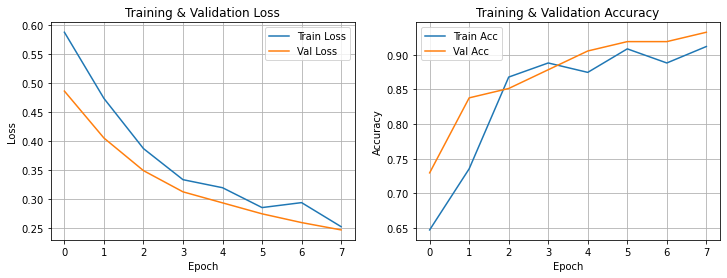

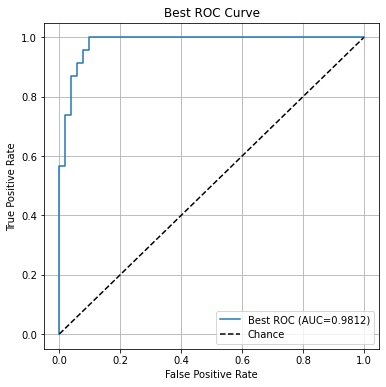

Best Precision: 0.8214
Best Recall:    1.0000
Best F1:        0.9020
Best AUC:       0.9812


In [13]:
# ===================================================
# 📊 Post‑Training Evaluation & Plots
# ===================================================
import matplotlib.pyplot as plt

(
    loss_hist_train, loss_hist_val,
    acc_hist_train, acc_hist_val,
    best_precision, best_recall, best_f1,
    best_fpr, best_tpr, best_auc
) = history

# ---- Loss curves ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_hist_train, label="Train Loss")
plt.plot(loss_hist_val, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# ---- Accuracy curves ----
plt.subplot(1, 2, 2)
plt.plot(acc_hist_train, label="Train Acc")
plt.plot(acc_hist_val, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---- Best ROC curve ----
if best_fpr.size > 0 and best_tpr.size > 0:
    plt.figure(figsize=(6, 6))
    plt.plot(best_fpr, best_tpr, label=f"Best ROC (AUC={best_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Best ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No ROC data available to plot.")

# ---- Print best metrics ----
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall:    {best_recall:.4f}")
print(f"Best F1:        {best_f1:.4f}")
print(f"Best AUC:       {best_auc:.4f}")


In [16]:
print(f'Precision Score: {history[4]}')
print(f'Recall Score: {history[5]}')
print(f'F1 Score: {history[6]}')
print(f'False Positive Rate: {history[7]}')
print(f'True Positive Rate: {history[8]}')
print(f'ROC AUC: {history[9]}')

Precision Score: 0.8214285714285714
Recall Score: 1.0
F1 Score: 0.9019607843137255
False Positive Rate: [0.         0.         0.         0.01960784 0.01960784 0.03921569
 0.03921569 0.05882353 0.05882353 0.07843137 0.07843137 0.09803922
 0.09803922 1.        ]
True Positive Rate: [0.         0.04347826 0.56521739 0.56521739 0.73913043 0.73913043
 0.86956522 0.86956522 0.91304348 0.91304348 0.95652174 0.95652174
 1.         1.        ]
ROC AUC: 0.9812446717817562


In [20]:
#PRINT LIST OF FILES USED FOR TRAINING

# For training set
train_files = []
if hasattr(trainloader.dataset, 'samples'):  # ImageFolder and similar
    train_files = [path for path, _ in trainloader.dataset.samples]
elif hasattr(trainloader.dataset, 'imgs'):  # older ImageFolder
    train_files = [path for path, _ in trainloader.dataset.imgs]
elif hasattr(trainloader.dataset, 'dataset'):  # Subset wrapper
    base_ds = trainloader.dataset.dataset
    if hasattr(base_ds, 'samples'):
        idxs = trainloader.dataset.indices
        train_files = [base_ds.samples[i][0] for i in idxs]

print("Training files:")
for f in train_files:
    print(f)

# For validation set
val_files = []
if hasattr(valloader.dataset, 'samples'):
    val_files = [path for path, _ in valloader.dataset.samples]
elif hasattr(valloader.dataset, 'imgs'):
    val_files = [path for path, _ in valloader.dataset.imgs]
elif hasattr(valloader.dataset, 'dataset'):
    base_ds = valloader.dataset.dataset
    if hasattr(base_ds, 'samples'):
        idxs = valloader.dataset.indices
        val_files = [base_ds.samples[i][0] for i in idxs]

print("Validation files:")
for f in val_files:
    print(f)


Training files:
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07461 - Copy.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07463 - Copy.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07465.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07470.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07490.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07492.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07499.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07508.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07510.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07512.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07518.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07521.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07523.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07526.jpg
/90daydata/nematode_ml/BLD/NematodeDataset/tra

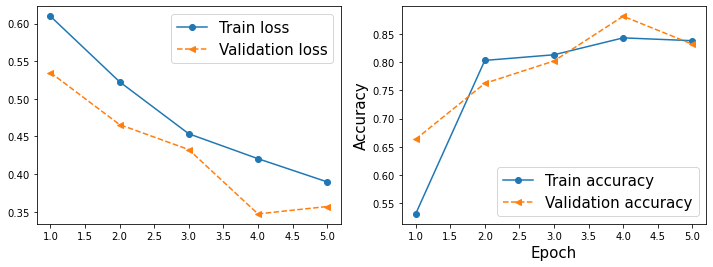

In [39]:
#Plot learning curve
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize = 15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, hist[3], '--<',
        label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size = 15)
ax.set_ylabel('Accuracy', size=15)
plt.show()




In [ ]:
#Gradcam
#https://medium.com/@evodopives/demystifying-cnn-decisions-a-practical-gradcam-implementation-in-pytorch-2d5692707b0d

features = None 
grads = None

# Forward hook: capture the output (feature maps)
def forward_hook(module, input, output):
    global features
    features = output.detach()

# Backward hook: capture the gradients from the output
def backward_hook(module, grad_in, grad_out):
    global grads
    grads = grad_out[0].detach()

In [ ]:
#import model

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.eval()

# Identify the last convolutional layer
target_layer = model.layer4[-1]

target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

In [ ]:
#model.eval()

In [ ]:
img_path = '/project/90daydata/nematode_ml/BLD/NematodeDataset/train/BLD/DSC07461 - Copy.jpg' 
img = Image.open(img_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

In [ ]:
output = model(input_tensor)

# Choose a class index (e.g., for demonstration)
class_idx = 0
score = output[0, class_idx]

model.zero_grad()
score.backward()

In [ ]:
# Compute weights: global average pooling over gradients
weights = torch.mean(grads, dim=(2, 3))  # Shape: [batch, channels]

# Compute the weighted combination of feature maps
cam = torch.sum(weights.unsqueeze(-1).unsqueeze(-1) * features, dim=1)

cam = F.relu(cam)

# Normalize the CAM to [0, 1]
cam = cam - cam.min()
cam = cam / cam.max()

In [ ]:
cam_np = cam[0].cpu().numpy()
cam_np = cv2.resize(cam_np, (224, 224))
cam_np = np.uint8(255 * cam_np)

# Apply a colormap (JET) and convert color channels from BGR to RGB
heatmap = cv2.applyColorMap(cam_np, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

img_np = np.array(img.resize((224, 224)))

# Overlay: 40% heatmap and 60% original image
overlay = heatmap * 0.4 + img_np * 0.6
overlay = np.uint8(np.clip(overlay, 0, 255))

plt.imshow(overlay)
plt.axis('off')
plt.show()